# x-ahead time series (sine wave) prediction with pytorch
- [original repo](https://github.com/pytorch/examples/tree/master/time_sequence_prediction)
- it illustrates how to implement model that does both training and prediction with the same code
- it uses an explicit loop over each element of a sequence

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import torch
from torch import nn, optim
from torch.autograd import Variable

## data generation

In [3]:
T, L, N = 20, 1000, 100
np.random.seed(0)
x = np.empty((N, L), 'float32')
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
data = np.sin(x / T).astype(np.float32)

print(data.shape, data.dtype)

(100, 1000) float32


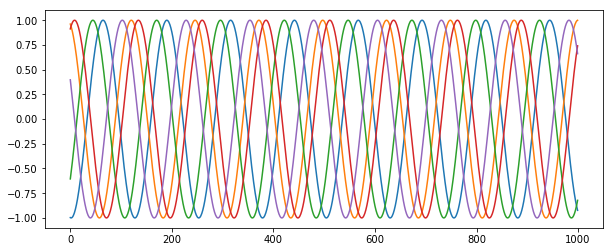

In [5]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.plot(data[i, :])

In [6]:
train_data = data[3:, :]
test_data = data[:3, :]

## sequence model

In [82]:
input_size = 1
output_size = input_size
hidden_size = 32

class SeqModel(nn.Module):
    def __init__(self):
        super(SeqModel, self).__init__()
        # two layer gru, with hidden size
        self.gru1 = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                           num_layers=1, bidirectional=False, batch_first=True)
        self.d = nn.Dropout(p=0.5)
        self.gru2 = nn.GRU(input_size=hidden_size, hidden_size=output_size,
                           num_layers=1, bidirectional=False, batch_first=True)
    def forward(self, x, future=0):
        """future: # of extra steps to predict beyond x.
        We do it one step each time with explicit loop
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        outs = []
        
        h1 = Variable(torch.zeros([1, batch_size, hidden_size]), requires_grad=False).cuda()
        h2 = Variable(torch.zeros([1, batch_size, output_size]), requires_grad=False).cuda()
        
        # rolling over the x sequence
        for i, xt in enumerate(x.chunk(seq_len, dim=1)):
            y1, h1 = self.gru1(xt, h1)
            y1 = self.d(y1)
            y2, h2 = self.gru2(y1, h2)
            outs.append(y2)
        # rolling beyond the x sequence into future
        for i in range(future):
            y1, h1 = self.gru1(y2, h1)
            y1 = self.d(y1)
            y2, h2 = self.gru2(y1, h2)
            outs.append(y2)
        return torch.cat(outs, dim=1)

In [83]:
## test model
m = SeqModel().cuda()
x = Variable(torch.randn([16, 32, 1])).cuda()
y = m(x, 10)
y.size()

torch.Size([16, 42, 1])

## training

In [84]:
objective = nn.MSELoss()
model = SeqModel().cuda()
model.train()
optimizer = optim.Adam(model.parameters(), lr=5e-2)
# optimizer = optim.LBFGS(model.parameters())

n_epochs = 500

for epoch in range(n_epochs):
    x = Variable(torch.from_numpy(np.expand_dims(train_data[:, :-1], 2))).cuda()
    y = Variable(torch.from_numpy(np.expand_dims(train_data[:, 1:], 2))).cuda()
    yhat = model(x)
    
    optimizer.zero_grad()
    loss = objective(yhat, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(epoch, loss.data[0])

0 1.3606436252593994
10 0.022656328976154327
20 0.012304847128689289
30 0.007285104598850012
40 0.005643438082188368
50 0.0038807597011327744
60 0.003270032349973917
70 0.002712575951591134
80 0.002350340597331524
90 0.0021693611051887274
100 0.0018328136065974832
110 0.001631114981137216
120 0.001499287085607648
130 0.0013638549717143178
140 0.0012924763141199946
150 0.001186144887469709
160 0.0010957795893773437
170 0.0011584782041609287
180 0.001014080480672419
190 0.0009359135874547064
200 0.0008834101026877761
210 0.0010681169806048274
220 0.000880215025972575
230 0.0008036798681132495
240 0.0007412373670376837
250 0.0007816039142198861
260 0.0007815434946678579
270 0.0008095228113234043
280 0.0007929025450721383
290 0.0007430774276144803
300 0.0006301228422671556
310 0.0006664175307378173
320 0.0006144941435195506
330 0.0006038133287802339
340 0.0006242571980692446
350 0.0005517137469723821
360 0.0005525124142877758
370 0.0006177679751999676
380 0.0005276487790979445
390 0.000545

## prediction

In [87]:
future = 1000
model.eval()

test =  test_data # train_data[:5,:]

test_x = Variable(torch.from_numpy(np.expand_dims(test, 2))).cuda()
test_yhat = model(test_x, future)
test_yhat_val = test_yhat.data.cpu().numpy().squeeze()

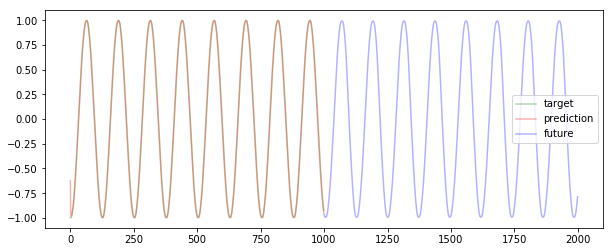

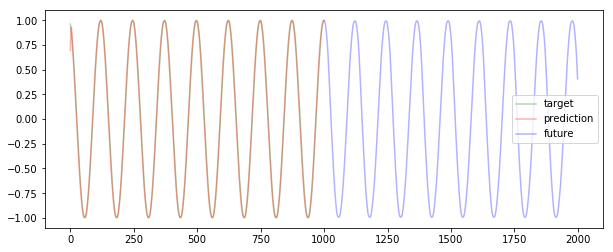

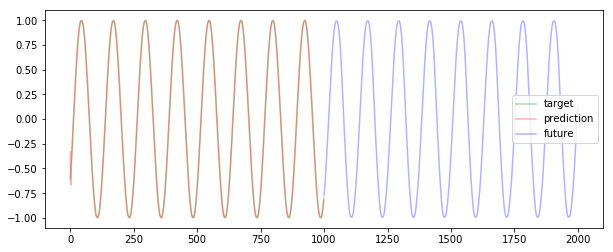

In [88]:
x_val = np.arange(test_yhat_val.shape[1])
for i in range(test_yhat_val.shape[0]):
    plt.figure(figsize=(10, 4))
    plt.plot(x_val[:-future], test[i, :], label="target", color="green", alpha=0.3)
    plt.plot(x_val[:-future], test_yhat_val[i, :-future], label="prediction", color="red", alpha=0.3)
    plt.plot(x_val[-future:], test_yhat_val[i, -future:], label="future", color="blue", alpha=0.3)
    plt.legend(loc="best")